In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats as stats

sys.path.insert(1, '../../../data/')
from datasets import Banana
sys.path.insert(1, '../../../methods/')
from TriangularEstimators import ScaledCostOT

plt.rcParams.update({'font.size': 20})

np.random.seed(69)

## Define dataset

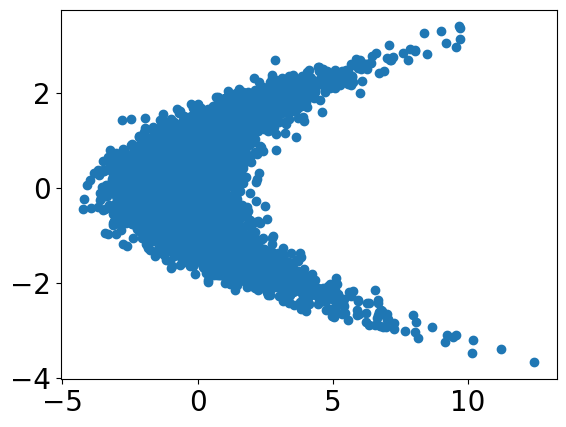

In [3]:
# define number of samples
N = 7500

# define class
pi = Banana(reverse=True)

# define source samples
X = pi.sample_joint(N)
X_source = np.hstack((X[:,0][:,None], np.random.randn(N,1)))

# define target samples
X_target = pi.sample_joint(N)

plt.scatter(X_target[:,0],X_target[:,1])

In [4]:
dim_x = dim_y = 1
beta = 6e-2

In [5]:
## ICNN model
n_iters_icnn = 5000 ### number of training iterations
ot_icnn = ScaledCostOT(dx1=dim_x,dx2=dim_y,beta=beta,estimator='ICNN', n_iters=n_iters_icnn) ## move this as a **args
ot_icnn.fit(source=X_source, target=X_target)
print('Done ICNN')
## Nearest-Neighbor estimator
if N <= 10000:
    ot_nn = ScaledCostOT(dx1=dim_x,dx2=dim_y,beta=beta,estimator='NN')
    ot_nn.fit(source=X_source, target=X_target)
    print('Done NN')
## Entropic map estimator
eps_ott = beta/5
n_inters_ott = 5000
ot_ott = ScaledCostOT(dx1=dim_x,dx2=dim_y,beta=beta,estimator='OTT',eps=eps_ott)
ot_ott.fit(source=X_source, target=X_target, max_iter=n_inters_ott)
print('Done OTT')

/Users/apooladian/anaconda3/lib/python3.11/site-packages/scipy/stats/_kde.py:588: RuntimeWarning: divide by zero encountered in log
  self.log_det = 2*np.log(np.diag(self.cho_cov


  0%|          | 0/1000 [00:00<?, ?it/s]

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Done ICNN
Done NN
Done OTT


[<matplotlib.patches.Rectangle object at 0x2ad2dec10>, <matplotlib.patches.Rectangle object at 0x2ad349510>, <matplotlib.patches.Rectangle object at 0x2b6875110>]
['$T_{\\text{MLP}}$', '$T_{\\text{NN}}$', '$T_{\\text{EOT}}$']


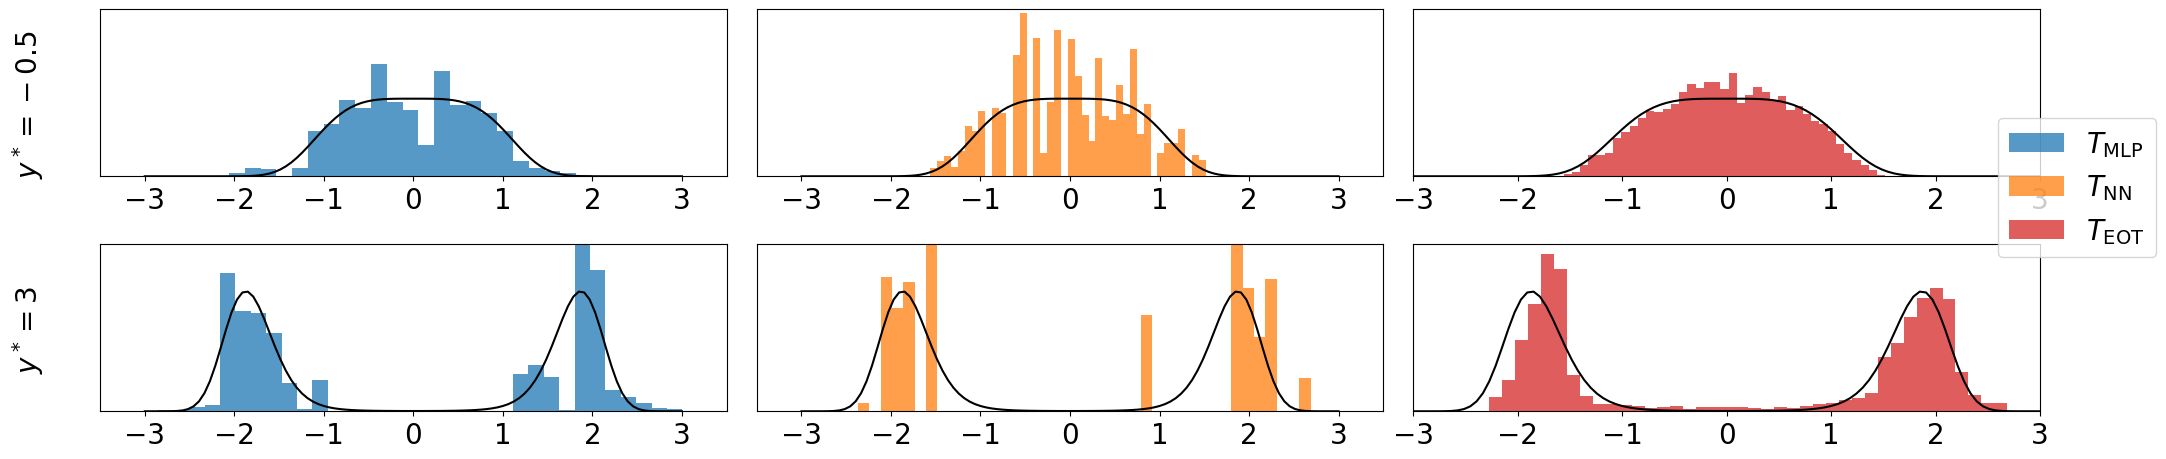

In [6]:
Ntest = int(5000)
y_locs = [-0.5,3]
nbins = 40

# Share a Y axis with each row of subplots
fig, ax = plt.subplots(2, 3, figsize = (20,5))

for i,y in enumerate(y_locs):
    data_cond_y = jnp.hstack((jnp.ones((Ntest,1))*y, jnp.array(np.random.randn(Ntest,1))))
    # evaluate conditional density
    xx = np.linspace(-3,3,100)[:,None]
    yy = np.ones_like(xx)*y
    pi_cond = pi.joint_pdf(np.hstack((yy,xx)))
    pi_cond = pi_cond/np.trapz(pi_cond, dx=(xx[1]-xx[0]))#, x=xx)
    #plt.subplot(2,3,i+1)
    #plt.plot(xx, pi_cond, c='black')

    #for j in range(3):
    YX_transp_icnn = ot_icnn.evaluate(data_cond_y)
    ax[i,0].hist(YX_transp_icnn[:,1], bins=nbins, density=True, label=r'$T_{\text{MLP}}$',alpha=.75, color='#1f77b4')
    ax[i,0].plot(xx, pi_cond, c='black')
    #ax.flatten()[i].hist(YX_transp_icnn[:,1], bins=nbins, density=True, label='MLP',alpha=.75)
    ax[i,0].set_ylim(0, 1.0)
    ax[i,0].set_xlim(-3.5, 3.5)
    ax[i,0].tick_params(left = False, right = False , labelleft = False) #labelbottom = False, bottom = False) 
    
    YX_transp_nn = ot_nn.evaluate(data_cond_y)
    ax[i,1].hist(YX_transp_nn[:,1], bins=nbins, density=True, label=r'$T_{\text{NN}}$',alpha=.75,color='#ff7f0e')
    ax[i,1].plot(xx, pi_cond, c='black')
    ax[i,1].set_ylim(0, 1.0)
    ax[i,1].set_xlim(-3.5, 3.5)
    ax[i,1].tick_params(left = False, right = False , labelleft = False) #labelbottom = False, bottom = False) 

    #ax.flatten()[i].hist(YX_transp_nn[:,1], bins=nbins, density=True, label='NN',alpha=.55)
    
    YX_transp_ott = ot_ott.evaluate(data_cond_y)
    ax[i,2].hist(YX_transp_ott[:,1], bins=nbins, density=True, label=r'$T_{\text{EOT}}$',alpha=.75,color='#d62728')
    ax[i,2].plot(xx, pi_cond, c='black')
    ax[i,2].set_ylim(0, 1.0)
    ax[i,2].set_xlim(-3, 3)
    ax[i,2].tick_params(left = False, right = False , labelleft = False) #labelbottom = False, bottom = False) 

    
# Creating a single legend for all plots
handles, labels = [], []
for a in ax[0,:]:  # Flatten to iterate over all subplots
    for h, l in zip(*a.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

print(handles)
print(labels)

# Adding a single legend outside the subplots
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 0.75))

# Adding row titles
fig.text(-0.03, 0.75, r'$y^*=-0.5$', va='center', rotation='vertical')
fig.text(-0.03, 0.3, r'$y^*=3$', va='center', rotation='vertical')

# # Adding column titles
# for i, col in enumerate(['Column 1', 'Column 2', 'Column 3']):
#     fig.text(0.25 + i * 0.25, 0.95, col, ha='center', fontsize=14)

plt.tight_layout()
plt.show()

    #ax.flatten()[i].hist(YX_transp_ott[:,1], bins=nbins, density=True, label='EOT',alpha=.75)
    
#     YX_transp_bridge = ot_ott.evaluate_bridge(data_cond_y, tau=0.95, Nsteps=500)
#     ax.flatten()[i].hist(YX_transp_bridge[:,1], bins=nbins, density=True, label='SB',alpha=.55)

    #ax.flatten()[i].legend(loc='lower left')
    #ax.flatten()[i].set_title()

    #ax.flatten()[i].set_ylim(0, 1.0)
    #ax.flatten()[i].tick_params(left = False, right = False , labelleft = False) #labelbottom = False, bottom = False) 
